In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.constants import mu_0

# Step 1: Generate a 3D Grid
def generate_3d_grid(x_range, y_range, z_range, num_points=20):
    x = np.linspace(*x_range, num_points)
    y = np.linspace(*y_range, num_points)
    z = np.linspace(*z_range, num_points)
    return np.meshgrid(x, y, z, indexing="ij")

# Step 2: Define Vector Potential A for Ideal Solenoid
def vector_potential_solenoid(N, I, R, grid):
    X, Y, Z = grid
    rho = np.sqrt(X**2 + Y**2) + 1e-9  # avoid division by zero
    A_phi = (mu_0 * N * I / (2 * np.pi)) * (1 / rho)
    Ax = -A_phi * Y / rho
    Ay = A_phi * X / rho
    Az = np.zeros_like(Z)
    return Ax, Ay, Az

# Step 3: Compute Magnetic Field B = ∇ × A
def compute_B_from_A(Ax, Ay, Az, grid_step):
    dAydz, dAydx = np.gradient(Ay, grid_step, axis=(2, 0))
    dAzdx, dAzdy = np.gradient(Az, grid_step, axis=(0, 1))
    dAxdz, dAxdy = np.gradient(Ax, grid_step, axis=(2, 1))
    Bx = dAydz - dAzdy
    By = dAzdx - dAxdz
    Bz = dAxdy - dAydx
    return Bx, By, Bz

# Step 4: Add Noise to Simulate Measurement Uncertainty
def add_noise(field, std_dev=0.02):
    return field + np.random.normal(0, std_dev, size=field.shape)

# Parameters
N, I, R = 1000, 5, 0.1
grid_step = 0.02
grid = generate_3d_grid((-0.2, 0.2), (-0.2, 0.2), (-0.5, 0.5), num_points=20)
Ax, Ay, Az = vector_potential_solenoid(N, I, R, grid)
Bx, By, Bz = compute_B_from_A(Ax, Ay, Az, grid_step)
Bz_noisy = add_noise(Bz, std_dev=0.02)


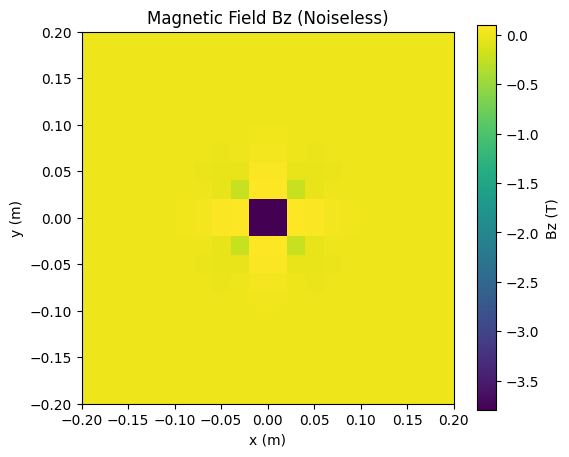

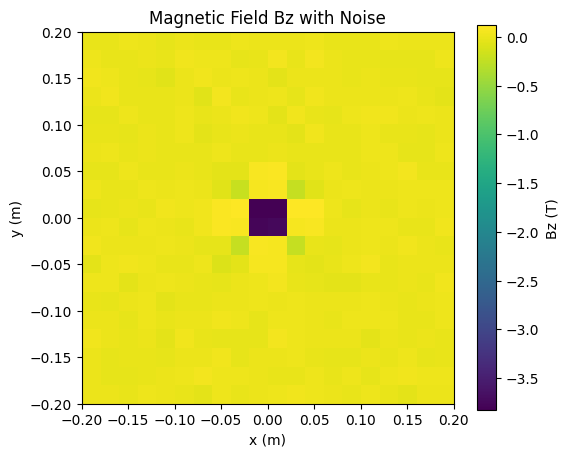

In [2]:
def plot_field_slice(Bz, title="Bz field"):
    mid_z = Bz.shape[2] // 2
    plt.figure(figsize=(6, 5))
    plt.imshow(Bz[:, :, mid_z], extent=(-0.2, 0.2, -0.2, 0.2), origin='lower', cmap='viridis')
    plt.colorbar(label='Bz (T)')
    plt.title(title)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.grid(False)
    plt.show()

plot_field_slice(Bz, "Magnetic Field Bz (Noiseless)")
plot_field_slice(Bz_noisy, "Magnetic Field Bz with Noise")


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import mu_0 as mu0
from scipy.signal import find_peaks


# Define lead lengths to test (in meters)
lead_lengths = [0.01, 0.05, 0.10]  # 1 cm, 5 cm, 10 cm
results = {}

# Simulation parameters
chi = 1e-2
noise_std = 0.001
num_trials = 1000
z_vals = np.linspace(-2, 2, 500)
R = 0.8
L = 1.0
g = 9.81

def Bz_scaled(z, R=0.8, L=1.0, B0=3.0):
    z1 = z - L / 2
    z2 = z + L / 2
    profile = (z2 / np.sqrt(R**2 + z2**2)) - (z1 / np.sqrt(R**2 + z1**2))
    profile_center = (L/2) / np.sqrt(R**2 + (L/2)**2) * 2
    return B0 * (profile / profile_center)

B_vals = Bz_scaled(z_vals)

# Run simulation for each lead length
for length in lead_lengths:
    mass = 0.000114 * (length / 0.05)  # Scale mass proportionally
    radius = 0.001 / 2
    volume = np.pi * radius**2 * length
    rho = mass / volume
    C = 1 / (mu0 * g * rho)

    max_force_ratios = []
    max_force_positions = []

    np.random.seed(42)
    for _ in range(num_trials):
        B_noisy = B_vals + np.random.normal(0, noise_std, size=B_vals.shape)
        dB_noisy = np.gradient(B_noisy, z_vals)
        F_trans_g = chi * C * (B_noisy * dB_noisy)

        max_idx = np.argmax(F_trans_g)
        max_force_ratios.append(F_trans_g[max_idx])
        max_force_positions.append(z_vals[max_idx])

    # Histogram and peak detection
    hist_counts, bin_edges = np.histogram(max_force_positions, bins=20, range=(-0.6, -0.2))
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    peaks, _ = find_peaks(hist_counts, distance=2)

    # Sort peaks by frequency
    sorted_indices = np.argsort(hist_counts[peaks])[::-1]
    peak_positions = bin_centers[peaks[sorted_indices[:2]]] if len(sorted_indices) >= 2 else []

    results[length] = peak_positions

results


{0.01: array([-0.43, -0.47]),
 0.05: array([-0.43, -0.47]),
 0.1: array([-0.43, -0.47])}